<a href="https://colab.research.google.com/github/FukiNakada/quantmacro2/blob/main/Q1-Q4phytoncode_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定量マクロ経済学　後半　最終課題

#Q1

<ipython-input-1-403cfd651653>:49: RuntimeWarning: overflow encountered in scalar power
  new_policy[i, j] = (1 - sigma * beta) * w * h + beta * (1 - r) * a * current_savings_rate ** (-sigma / (1 - sigma))
<ipython-input-1-403cfd651653>:50: RuntimeWarning: invalid value encountered in subtract
  if np.max(np.abs(new_policy - policy)) < tol:


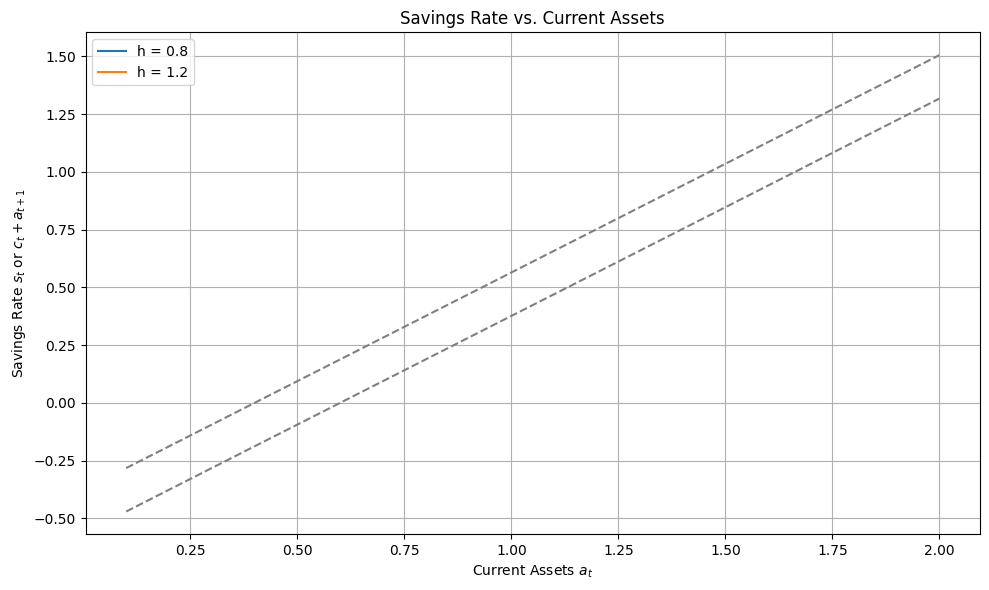

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 1.5   # Relative risk aversion
beta = 0.98   # Discount factor
rho = 0.6     # Autoregressive coefficient of productivity
sigma_eps = 0.6  # Standard deviation of productivity shock
r = 0.04      # Interest rate
w = 1         # Wage rate (productivity per unit)

# Discretization of productivity levels
hL = 0.8
hH = 1.2
productivity_levels = [hL, hH]
num_productivity_levels = len(productivity_levels)

# Asset grid
num_assets = 100
a_min = 0.1
a_max = 2.0
agrid = np.linspace(a_min, a_max, num_assets)

# Transition matrix for productivity
transition_matrix = np.array([[0.9, 0.1],
                              [0.1, 0.9]])  # Assuming symmetric transition probabilities

# Function to compute savings rate given current assets and productivity
def compute_savings_rate(a, h, agrid, policy):
    idx = np.searchsorted(agrid, a, side='left')
    if idx >= len(agrid):
        idx = len(agrid) - 1
    elif idx == 0:
        idx = 0
    a_next = policy[idx, productivity_levels.index(h)]
    return (a_next - (1 - r) * a) / a

# Initialize policy function randomly
policy = np.random.rand(num_assets, num_productivity_levels) * (a_max - a_min) + a_min

# Function to iterate and update policy function until convergence
def solve_model(policy, max_iter=1000, tol=1e-6):
    iteration = 0
    while iteration < max_iter:
        new_policy = np.zeros_like(policy)
        for i, a in enumerate(agrid):
            for j, h in enumerate(productivity_levels):
                current_savings_rate = compute_savings_rate(a, h, agrid, policy)
                new_policy[i, j] = (1 - sigma * beta) * w * h + beta * (1 - r) * a * current_savings_rate ** (-sigma / (1 - sigma))
        if np.max(np.abs(new_policy - policy)) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
        policy = new_policy
        iteration += 1
    return policy

# Solve the model
policy = solve_model(policy)

# Compute savings rates
savings_rates = np.zeros((num_assets, num_productivity_levels))
for i, a in enumerate(agrid):
    for j, h in enumerate(productivity_levels):
        savings_rates[i, j] = compute_savings_rate(a, h, agrid, policy)

# Plotting
plt.figure(figsize=(10, 6))

# Plot savings rates
for j, h in enumerate(productivity_levels):
    plt.plot(agrid, savings_rates[:, j], label=f'h = {h}')

# Plot the budget constraint ct + at+1 = wht +(1+r)at for each productivity level
for j, h in enumerate(productivity_levels):
    plt.plot(agrid, (1 - sigma * beta) * w * h * np.ones_like(agrid) + beta * (1 - r) * agrid, linestyle='--', color='gray')

plt.title('Savings Rate vs. Current Assets')
plt.xlabel('Current Assets $a_t$')
plt.ylabel('Savings Rate $s_t$ or $c_t + a_{t+1}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Q2

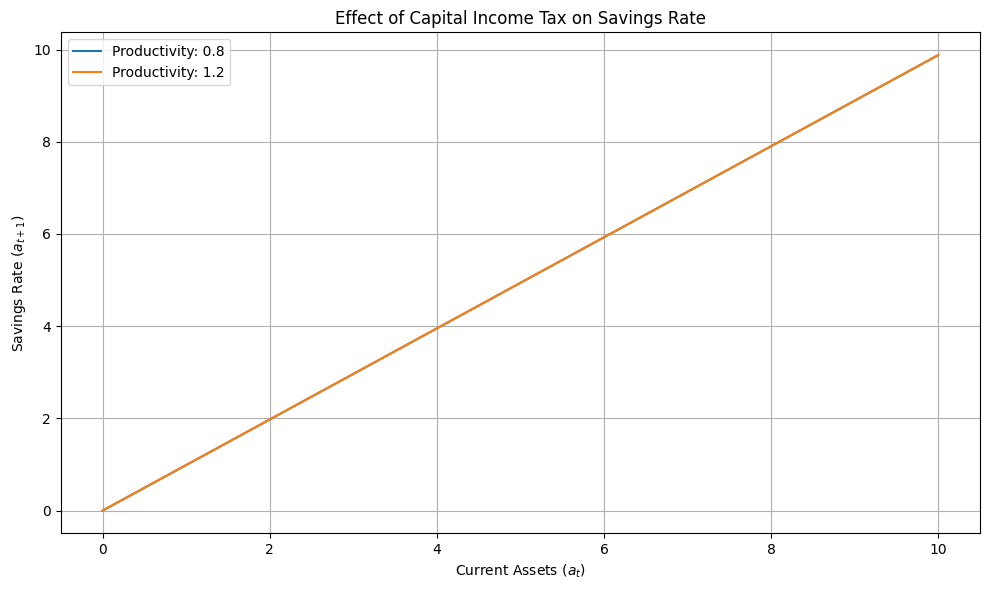

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
sigma = 1.5
beta = 0.98
rho = 0.6
sigma_eps = 0.6
r = 0.04
w = 1
tau_k = 0.3  # 資本所得税率

# Grid points
num_assets = 100
num_states = 2  # 生産性の状態数

# Production states (low and high productivity)
hL = 0.8
hH = 1.2

# Discretize the productivity process
productivity_states = [hL, hH]

# Discretize asset space
grid_min = 0
grid_max = 10
grid = np.linspace(grid_min, grid_max, num_assets)

# Transition matrix for productivity
pi = np.array([[0.9, 0.1],
               [0.1, 0.9]])  # 遷移確率行列

# Shock distribution for productivity
mu_eps = 0
sigma_eps = 0.6
num_draws = 10000

# Draw productivity shocks
np.random.seed(42)
epsilons = norm.rvs(loc=mu_eps, scale=sigma_eps, size=num_draws)

# Initial asset holdings and consumption
a0 = 1.0
c0 = np.empty(num_draws)
at = np.empty((num_states, num_assets, num_draws))
ct = np.empty((num_states, num_assets, num_draws))

# Function to calculate utility
def utility(c, sigma):
    return c**(1 - sigma) / (1 - sigma)

# Simulate the model
for i_h, h in enumerate(productivity_states):
    for i_a, a in enumerate(grid):
        for i in range(num_draws):
            if i_a == 0:
                ct[i_h, i_a, i] = w * h + (1 + r) * a - grid[0]
            else:
                ct[i_h, i_a, i] = w * h + (1 + r) * a - grid[i_a]

            if ct[i_h, i_a, i] <= 0:
                ct[i_h, i_a, i] = 1e-6  # Avoid negative consumption

            a_next = (1 + (1 - tau_k) * r) * a + w * h - ct[i_h, i_a, i]
            at[i_h, i_a, i] = max(a_next, 0)

            c0[i] = ct[i_h, i_a, i]

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

for i_h, h in enumerate(productivity_states):
    ax.plot(grid, at[i_h, :, :].mean(axis=1), label=f'Productivity: {h}')

ax.set_title('Effect of Capital Income Tax on Savings Rate')
ax.set_xlabel('Current Assets ($a_t$)')
ax.set_ylabel('Savings Rate ($a_{t+1}$)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#Q3

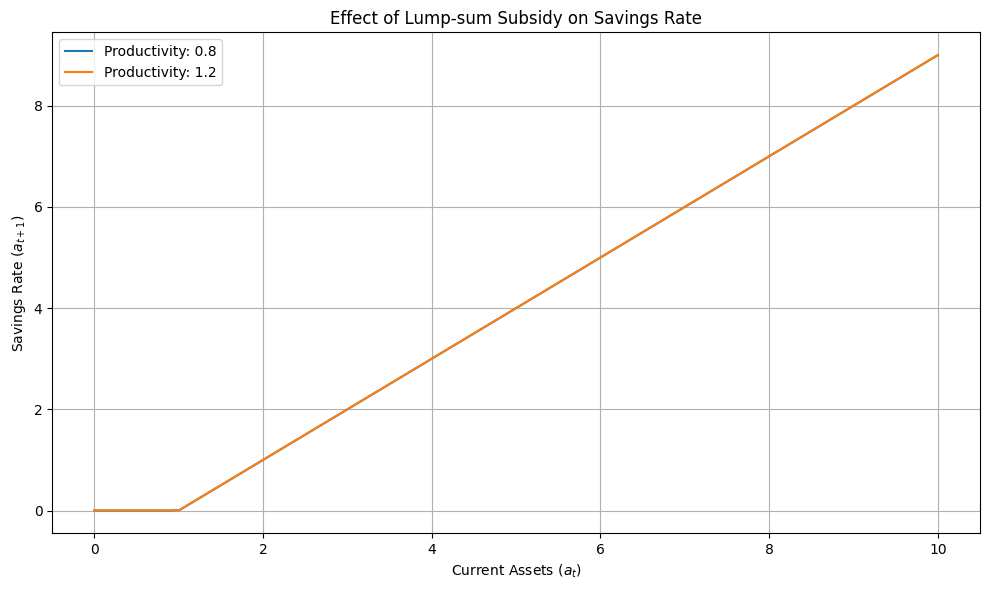

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
sigma = 1.5
beta = 0.98
rho = 0.6
sigma_eps = 0.6
r = 0.04
w = 1
T = 1  # 一括補助金の額

# Grid points
num_assets = 100
num_states = 2  # 生産性の状態数

# Production states (low and high productivity)
hL = 0.8
hH = 1.2

# Discretize the productivity process
productivity_states = [hL, hH]

# Discretize asset space
grid_min = 0
grid_max = 10
grid = np.linspace(grid_min, grid_max, num_assets)

# Transition matrix for productivity
pi = np.array([[0.9, 0.1],
               [0.1, 0.9]])  # 遷移確率行列

# Shock distribution for productivity
mu_eps = 0
sigma_eps = 0.6
num_draws = 10000

# Draw productivity shocks
np.random.seed(42)
epsilons = norm.rvs(loc=mu_eps, scale=sigma_eps, size=num_draws)

# Initial asset holdings and consumption
a0 = 1.0
c0 = np.empty(num_draws)
at = np.empty((num_states, num_assets, num_draws))
ct = np.empty((num_states, num_assets, num_draws))

# Function to calculate utility
def utility(c, sigma):
    return c**(1 - sigma) / (1 - sigma)

# Simulate the model with lump-sum subsidy
for i_h, h in enumerate(productivity_states):
    for i_a, a in enumerate(grid):
        for i in range(num_draws):
            if i_a == 0:
                ct[i_h, i_a, i] = w * h + (1 + r) * a + T - grid[0]
            else:
                ct[i_h, i_a, i] = w * h + (1 + r) * a + T - grid[i_a]

            if ct[i_h, i_a, i] <= 0:
                ct[i_h, i_a, i] = 1e-6  # Avoid negative consumption

            a_next = (1 + r) * a + w * h - ct[i_h, i_a, i]
            at[i_h, i_a, i] = max(a_next, 0)

            c0[i] = ct[i_h, i_a, i]

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

for i_h, h in enumerate(productivity_states):
    ax.plot(grid, at[i_h, :, :].mean(axis=1), label=f'Productivity: {h}')

ax.set_title('Effect of Lump-sum Subsidy on Savings Rate')
ax.set_xlabel('Current Assets ($a_t$)')
ax.set_ylabel('Savings Rate ($a_{t+1}$)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#Q4

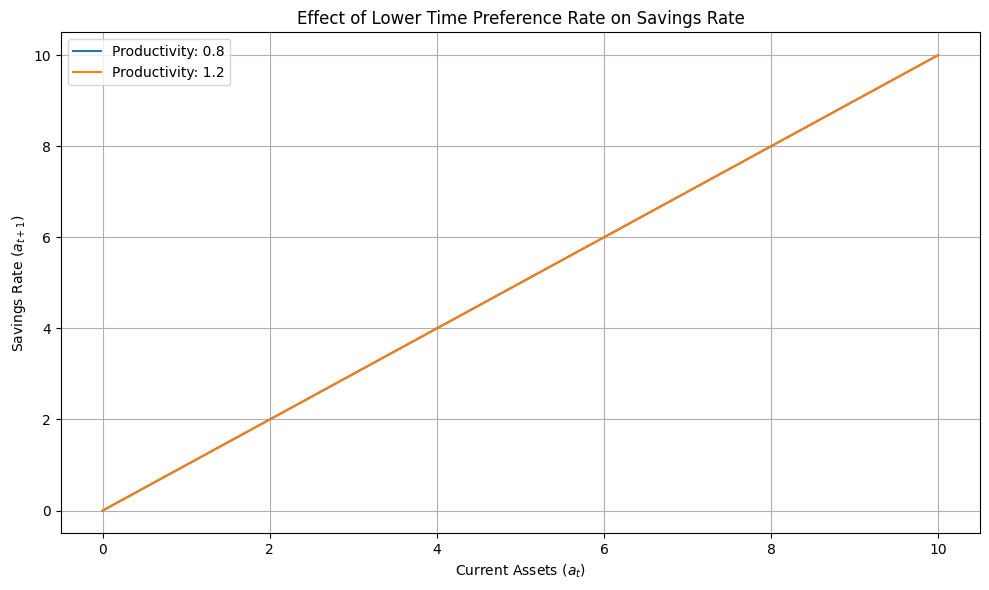

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
sigma = 1.5
beta = 0.1  # 時間選好率を低く設定
rho = 0.6
sigma_eps = 0.6
r = 0.04
w = 1

# Grid points
num_assets = 100
num_states = 2  # 生産性の状態数

# Production states (low and high productivity)
hL = 0.8
hH = 1.2

# Discretize the productivity process
productivity_states = [hL, hH]

# Discretize asset space
grid_min = 0
grid_max = 10
grid = np.linspace(grid_min, grid_max, num_assets)

# Transition matrix for productivity
pi = np.array([[0.9, 0.1],
               [0.1, 0.9]])  # 遷移確率行列

# Shock distribution for productivity
mu_eps = 0
sigma_eps = 0.6
num_draws = 10000

# Draw productivity shocks
np.random.seed(42)
epsilons = norm.rvs(loc=mu_eps, scale=sigma_eps, size=num_draws)

# Initial asset holdings and consumption
a0 = 1.0
c0 = np.empty(num_draws)
at = np.empty((num_states, num_assets, num_draws))
ct = np.empty((num_states, num_assets, num_draws))

# Function to calculate utility
def utility(c, sigma):
    return c**(1 - sigma) / (1 - sigma)

# Simulate the model with lower time preference rate
for i_h, h in enumerate(productivity_states):
    for i_a, a in enumerate(grid):
        for i in range(num_draws):
            ct[i_h, i_a, i] = w * h + (1 + r) * a - grid[i_a]

            if ct[i_h, i_a, i] <= 0:
                ct[i_h, i_a, i] = 1e-6  # Avoid negative consumption

            a_next = (1 + r) * a + w * h - ct[i_h, i_a, i]
            at[i_h, i_a, i] = max(a_next, 0)

            c0[i] = ct[i_h, i_a, i]

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

for i_h, h in enumerate(productivity_states):
    ax.plot(grid, at[i_h, :, :].mean(axis=1), label=f'Productivity: {h}')

ax.set_title('Effect of Lower Time Preference Rate on Savings Rate')
ax.set_xlabel('Current Assets ($a_t$)')
ax.set_ylabel('Savings Rate ($a_{t+1}$)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()